**Historical** stock price data for Apple (AAPL) from Yahoo Finance via yfinance

In [1]:
!pip install yfinance --quiet

import yfinance as yf
import pandas as pd

# Download AAPL stock data (5 years)
df = yf.download('AAPL', start='2018-01-01', end='2023-12-31')
df = df[['Close']]  # We’ll use only closing price
df.head()


<ipython-input-1-2591545532>:7: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download('AAPL', start='2018-01-01', end='2023-12-31')
[*********************100%***********************]  1 of 1 completed


Price,Close
Ticker,AAPL
Date,
2018-01-02,40.426815
2018-01-03,40.419781
2018-01-04,40.607533
2018-01-05,41.069855
2018-01-08,40.917324


Data Preprocessing for LSTM

Step 1: Scaling the Data

In [2]:
from sklearn.preprocessing import MinMaxScaler
import numpy as np

scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df)

scaled_data[:5]  # view first 5 scaled values


array([[0.04027037],
       [0.04022716],
       [0.04138044],
       [0.04422027],
       [0.04328334]])

 Step 2: Create Sequences for LSTM

In [3]:
X = []
y = []

sequence_length = 60

for i in range(sequence_length, len(scaled_data)):
    X.append(scaled_data[i-sequence_length:i, 0])
    y.append(scaled_data[i, 0])

X = np.array(X)
y = np.array(y)

# Reshape X for LSTM: [samples, time steps, features]
X = X.reshape((X.shape[0], X.shape[1], 1))

print(f"X shape: {X.shape}, y shape: {y.shape}")


X shape: (1449, 60, 1), y shape: (1449,)


Build & Train the LSTM Model

In [4]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(60, 1)),
    Dropout(0.2),
    LSTM(50, return_sequences=False),
    Dropout(0.2),
    Dense(1)  # Output = 1 predicted value
])

model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
history = model.fit(X, y, epochs=10, batch_size=32, verbose=1)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 9s 60ms/step - loss: 0.0855
Epoch 2/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 3s 65ms/step - loss: 0.0053
Epoch 3/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 3s 67ms/step - loss: 0.0039
Epoch 4/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 5s 107ms/step - loss: 0.0042
Epoch 5/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 3s 73ms/step - loss: 0.0037
Epoch 6/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 3s 63ms/step - loss: 0.0033
Epoch 7/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 7s 105ms/step - loss: 0.0039
Epoch 8/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 3s 62ms/step - loss: 0.0034
Epoch 9/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 5s 65ms/step - loss: 0.0029
Epoch 10/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 6s 88ms/step - loss: 0.0030


Visualize Predicted vs Actual (on Training Data)

46/46 ━━━━━━━━━━━━━━━━━━━━ 4s 61ms/step


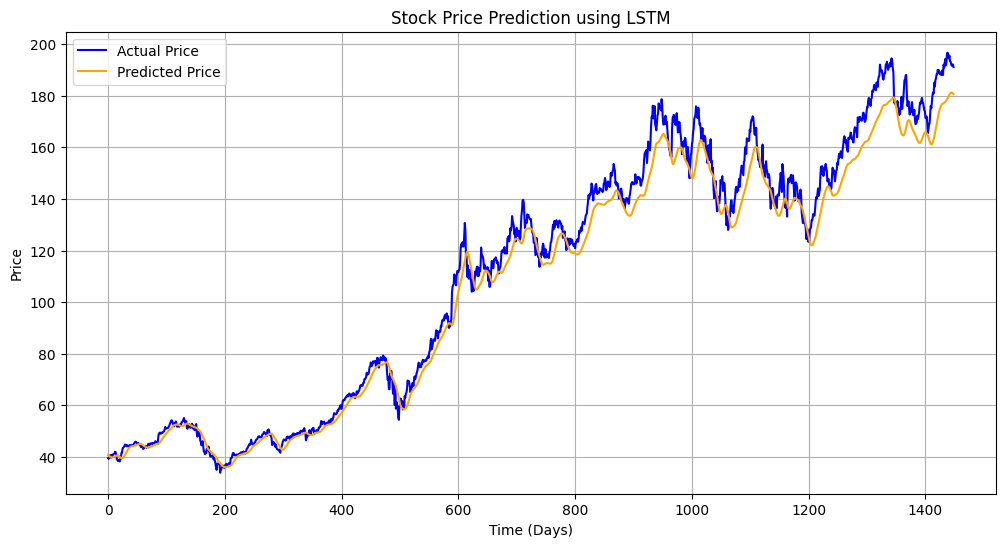

In [5]:
import matplotlib.pyplot as plt

# Predict on training data
predicted_prices = model.predict(X)

# Inverse scale the predicted and true values
predicted_prices_rescaled = scaler.inverse_transform(predicted_prices)
actual_prices_rescaled = scaler.inverse_transform(y.reshape(-1, 1))

# Plot
plt.figure(figsize=(12,6))
plt.plot(actual_prices_rescaled, label='Actual Price', color='blue')
plt.plot(predicted_prices_rescaled, label='Predicted Price', color='orange')
plt.title('Stock Price Prediction using LSTM')
plt.xlabel('Time (Days)')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()


Predict the Next Day’s Closing Price

In [6]:
# Get last 60 closing prices from the scaled data
last_60_days = scaled_data[-60:]

# Reshape to match LSTM input
next_input = last_60_days.reshape(1, 60, 1)

# Predict next day
predicted_scaled_price = model.predict(next_input)

# Inverse transform to get the real price
predicted_price = scaler.inverse_transform(predicted_scaled_price)

print(f"📈 Predicted Next Day Closing Price: ${predicted_price[0][0]:.2f}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
📈 Predicted Next Day Closing Price: $180.38
